In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
import os
COUNTRY = "togo"                 # <-- set this per notebook (e.g. "benin")
RAW_PATH = f"../data/{COUNTRY}.csv"  # input file (not committed)
CLEAN_PATH = f"../data/{COUNTRY}_clean.csv"  # output (don't commit)


# ignore warnings
warnings.filterwarnings("ignore")


# plotting niceties
sns.set(style="whitegrid", rc={"figure.figsize": (10, 5)})
plt.rcParams["figure.dpi"] = 110

Load Data

In [2]:
# Load data with safe checks
assert Path(RAW_PATH).exists(), f"Input file not found: {RAW_PATH}"
df = pd.read_csv(RAW_PATH, parse_dates=True, infer_datetime_format=True)

# If Timestamp column exists but not parsed:
for c in df.columns:
    if "time" in c.lower() or "date" in c.lower():
        df.rename(columns={c: "Timestamp"}, inplace=True)
        break

if "Timestamp" in df.columns:
    df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Timestamp      525600 non-null  datetime64[ns]
 1   GHI            525600 non-null  float64       
 2   DNI            525600 non-null  float64       
 3   DHI            525600 non-null  float64       
 4   ModA           525600 non-null  float64       
 5   ModB           525600 non-null  float64       
 6   Tamb           525600 non-null  float64       
 7   RH             525600 non-null  float64       
 8   WS             525600 non-null  float64       
 9   WSgust         525600 non-null  float64       
 10  WSstdev        525600 non-null  float64       
 11  WD             525600 non-null  float64       
 12  WDstdev        525600 non-null  float64       
 13  BP             525600 non-null  int64         
 14  Cleaning       525600 non-null  int64         
 15  

,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-10-25 00:01:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.5,0.9,1.1,0.4,227.6,1.1,977,0,0.0,24.7,24.4,NaN
1,2021-10-25 00:02:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.1,1.6,0.4,229.3,0.7,977,0,0.0,24.7,24.4,NaN
2,2021-10-25 00:03:00,-1.3,0.0,0.0,0.0,0.0,24.8,94.4,1.2,1.4,0.3,228.5,2.9,977,0,0.0,24.7,24.4,NaN
3,2021-10-25 00:04:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.3,1.2,1.6,0.3,229.1,4.6,977,0,0.0,24.7,24.4,NaN
4,2021-10-25 00:05:00,-1.2,0.0,0.0,0.0,0.0,24.8,94.0,1.3,1.6,0.4,227.5,1.6,977,0,0.0,24.7,24.4,NaN


Columns of interest and basic cleanup

In [3]:
# Columns of interest and basic cleanup
# Adjust these lists if your dataset uses different column names.
NUMERIC_COLS = ["GHI", "DNI", "DHI", "ModA", "ModB",
                "WS", "WSgust", "Tamb", "RH", "WD", "BP"]
# Make sure columns that exist are used
NUMERIC_COLS = [c for c in NUMERIC_COLS if c in df.columns]

# Quick coercion to numeric (force non-numeric -> NaN)
df[NUMERIC_COLS] = df[NUMERIC_COLS].apply(pd.to_numeric, errors="coerce")

1. Summary statistics & missing-value report

In [4]:
# Summary statistics & missing-value report
def profile_df(d: pd.DataFrame, numeric_cols=None):
    print("Shape:", d.shape)
    print("\n--- Missing values ---")
    miss = d.isna().sum().sort_values(ascending=False)
    miss_pct = (miss / len(d) * 100).round(2)
    missing_report = pd.concat([miss, miss_pct], axis=1)
    missing_report.columns = ["missing_count", "missing_pct"]
    display(missing_report[missing_report["missing_count"] > 0])
    if numeric_cols:
        print("\n--- Numeric summary ---")
        display(d[numeric_cols].describe().T)
        high_nulls = missing_report[missing_report["missing_pct"] > 5]
        if not high_nulls.empty:
            print("\nColumns with >5% nulls:")
            display(high_nulls)
    else:
        display(d.describe().T)


profile_df(df, numeric_cols=NUMERIC_COLS)

Shape: (525600, 19)

--- Missing values ---


,missing_count,missing_pct
Comments,525600,100.0



--- Numeric summary ---


,count,mean,std,min,25%,50%,75%,max
GHI,525600.0,230.555040,322.532347,-12.7,-2.2,2.1,442.400,1424.0
DNI,525600.0,151.258469,250.956962,0.0,0.0,0.0,246.400,1004.5
DHI,525600.0,116.444352,156.520714,0.0,0.0,2.5,215.700,805.7
ModA,525600.0,226.144375,317.346938,0.0,0.0,4.4,422.525,1380.0
ModB,525600.0,219.568588,307.932510,0.0,0.0,4.3,411.000,1367.0
WS,525600.0,2.368093,1.462668,0.0,1.4,2.2,3.200,16.1
WSgust,525600.0,3.229490,1.882565,0.0,1.9,2.9,4.400,23.1
Tamb,525600.0,27.751788,4.758023,14.9,24.2,27.2,31.100,41.4
RH,525600.0,55.013160,28.778732,3.3,26.5,59.3,80.800,99.8
WD,525600.0,161.741845,91.877217,0.0,74.8,199.1,233.500,360.0



Columns with >5% nulls:


,missing_count,missing_pct
Comments,525600,100.0


2. Outlier detection via Z-score and flagging

In [5]:
# Outlier detection via Z-score and flagging
# Compute Z-scores for the specified columns
Z_COLS = ["GHI", "DNI", "DHI", "ModA", "ModB", "WS", "WSgust"]
Z_COLS = [c for c in Z_COLS if c in df.columns]

z_scores = df[Z_COLS].apply(lambda x: stats.zscore(x, nan_policy="omit"))
# zscore returns nan for constant series; handle that
z_scores = z_scores.replace([np.inf, -np.inf], np.nan)

# Flag rows with any |Z| > 3
outlier_mask = (z_scores.abs() > 3).any(axis=1)
df["_is_outlier_z3"] = outlier_mask

print("Outlier counts (|Z|>3):", df["_is_outlier_z3"].sum())

Outlier counts (|Z|>3): 9251


3. Missing-value handling & cleaning strategy

In [6]:
# Missing-value handling & cleaning strategy
# Strategy:
#  - For core numeric sensor columns: median imputation
#  - For Timestamp: drop rows where Timestamp missing
#  - Mark rows that were cleaned (imputed or outlier-handled)

CLEAN_COLS = Z_COLS.copy()  # same core columns
df["_was_missing"] = df[CLEAN_COLS].isna().any(axis=1)

# Drop rows with missing Timestamp (can't analyze time-series)
if "Timestamp" in df.columns:
    missing_ts = df["Timestamp"].isna().sum()
    if missing_ts:
        print(f"Dropping {missing_ts} rows with missing Timestamp")
        df = df[~df["Timestamp"].isna()].copy()
else:
    print("No Timestamp column detected; skip time-based operations.")

# Median impute
medians = df[CLEAN_COLS].median()
df_imputed = df.copy()
df_imputed[CLEAN_COLS] = df_imputed[CLEAN_COLS].fillna(medians)

# Optional: For extreme outliers (|z|>5), set to NaN -> then impute
extreme_mask = (z_scores.abs() > 5).any(axis=1) if not z_scores.empty else pd.Series(False, index=df.index)
print("Extreme outliers (|Z|>5):", extreme_mask.sum())
df_imputed.loc[extreme_mask, CLEAN_COLS] = df_imputed.loc[extreme_mask, CLEAN_COLS].where(~extreme_mask, np.nan)
df_imputed[CLEAN_COLS] = df_imputed[CLEAN_COLS].fillna(medians)

# Mark rows that changed due to cleaning (imputed or outlier)
df_imputed["_cleaned_flag"] = df["_was_missing"] | df["_is_outlier_z3"] | extreme_mask

# Replace df with cleaned copy for subsequent analysis
df_clean = df_imputed.copy()
print("Cleaned shape:", df_clean.shape)


Extreme outliers (|Z|>5): 459
Cleaned shape: (525600, 22)


4. Export Cleaned Data frame


In [7]:
# Export cleaned DataFrame
os.makedirs("data", exist_ok=True)
df_clean.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned CSV to", CLEAN_PATH)

Saved cleaned CSV to ../data/togo_clean.csv


Time series visualization (GHI, DNI, DHI, Tamb)

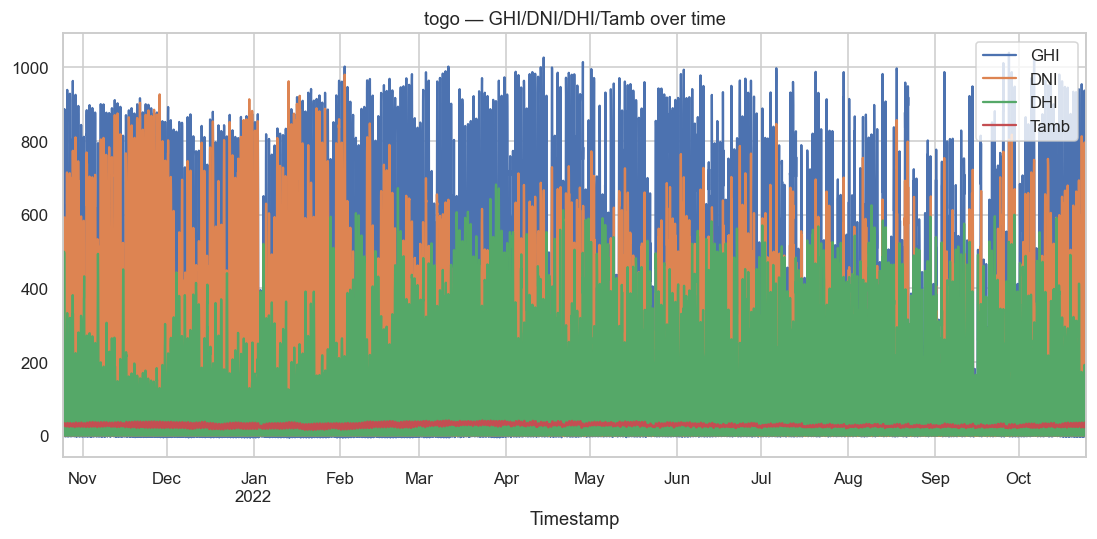

In [8]:
#  Time series visualization (GHI, DNI, DHI, Tamb)
# If no Timestamp, skip
if "Timestamp" in df_clean.columns:
    df_clean = df_clean.sort_values("Timestamp")
    ts_cols = [c for c in ["GHI", "DNI", "DHI", "Tamb"]
               if c in df_clean.columns]
    # resample to hourly mean for readability (if high-frequency)
    if pd.infer_freq(df_clean["Timestamp"].dropna()) is not None:
        df_ts = df_clean.set_index("Timestamp")[ts_cols].resample("1H").mean()
    else:
        df_ts = df_clean.set_index("Timestamp")[ts_cols]
    df_ts.plot(subplots=False, figsize=(12, 5),
               title=f"{COUNTRY} — GHI/DNI/DHI/Tamb over time")
    plt.xlabel("Timestamp")
    plt.show()
else:
    print("No Timestamp: skipping time series plots")

Monthly and Daily Patterns

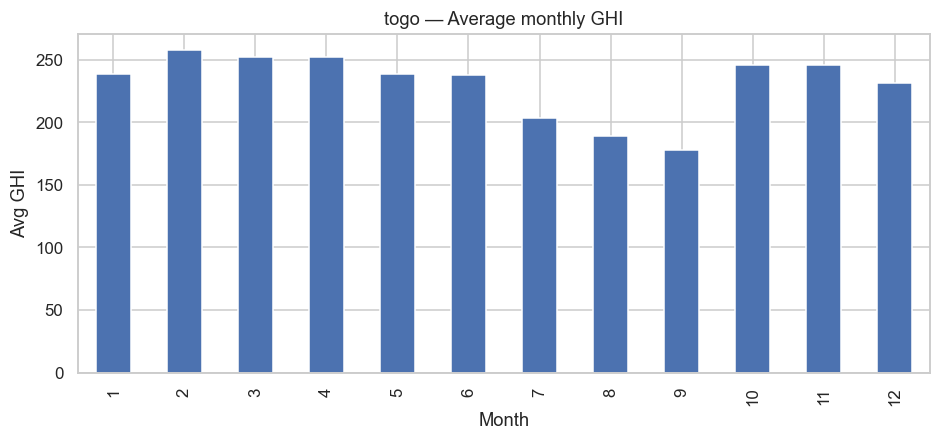

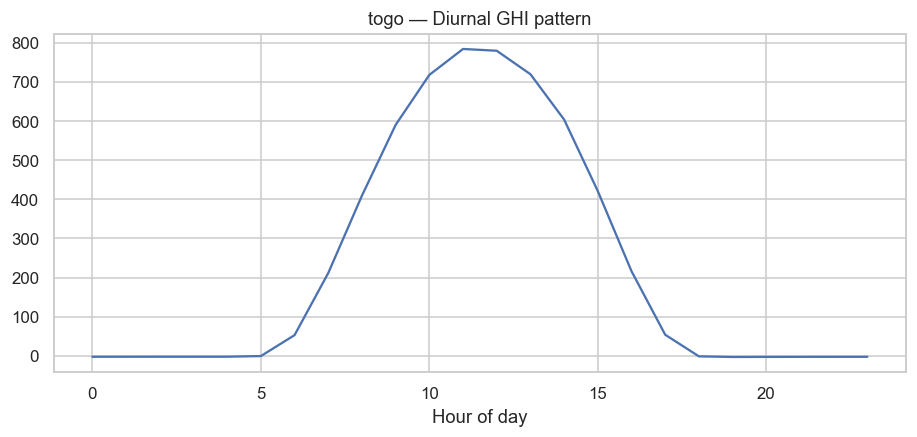

In [9]:
if "Timestamp" in df_clean.columns:
    df_clean["month"] = df_clean["Timestamp"].dt.month
    df_clean["hour"] = df_clean["Timestamp"].dt.hour

    # monthly average GHI
    if "GHI" in df_clean.columns:
        monthly = df_clean.groupby("month")["GHI"].mean()
        monthly.plot(
            kind="bar", title=f"{COUNTRY} — Average monthly GHI", figsize=(10, 4))
        plt.xlabel("Month")
        plt.ylabel("Avg GHI")
        plt.show()

    # diurnal pattern
    diurnal = df_clean.groupby("hour")["GHI"].agg(["mean", "median", "std"])
    diurnal["mean"].plot(
        title=f"{COUNTRY} — Diurnal GHI pattern", figsize=(10, 4))
    plt.xlabel("Hour of day")
    plt.show()

Cleaning impact: pre/post comparison for ModA & ModB

,pre,post
ModA,226.144375,226.137611
ModB,219.568588,219.561976


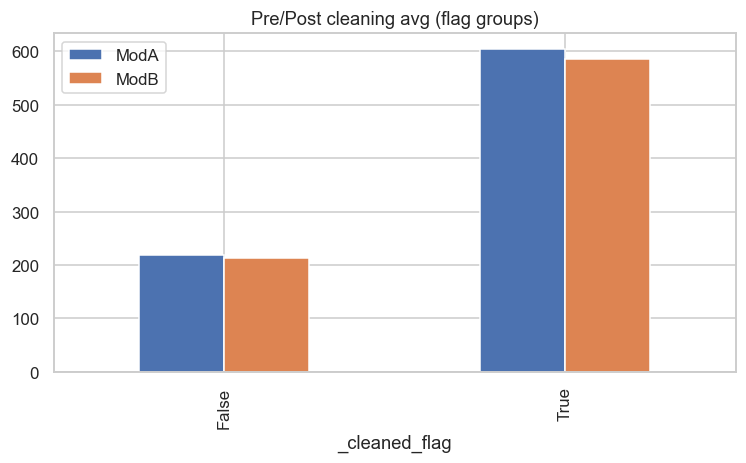

In [10]:
cols_compare = [c for c in ["ModA", "ModB"] if c in df.columns]
if cols_compare:
    pre = df[cols_compare].mean()
    post = df_clean[cols_compare].mean()
    cmp = pd.concat([pre.rename("pre"), post.rename("post")], axis=1)
    display(cmp)

    # Plot group by cleaned flag
    df_clean.groupby("_cleaned_flag")[cols_compare].mean().plot(
        kind="bar", figsize=(8, 4), title="Pre/Post cleaning avg (flag groups)")
    plt.show()
else:
    print("No ModA/ModB columns available for pre/post cleaning comparison.")

Correlation heatmap and scatter plots

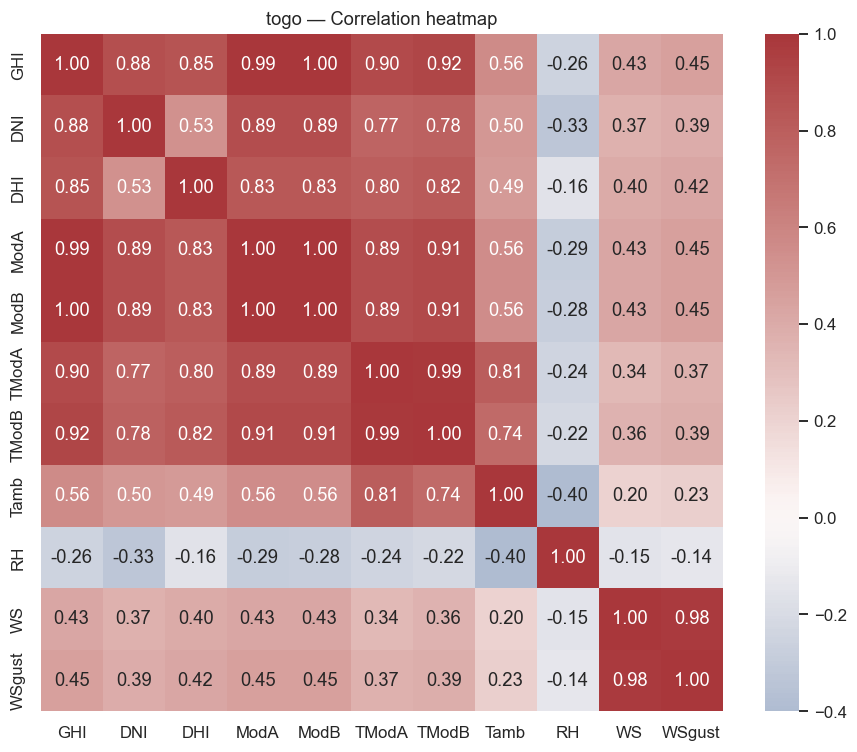

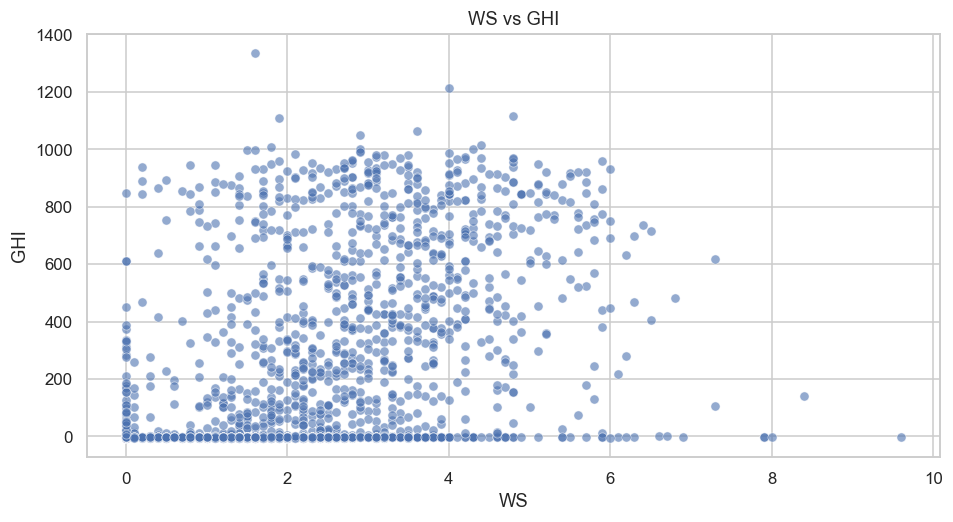

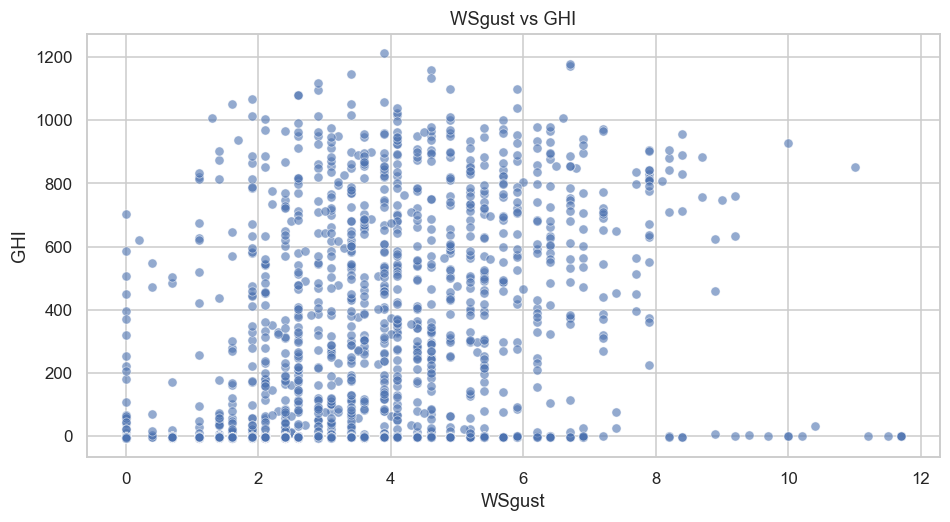

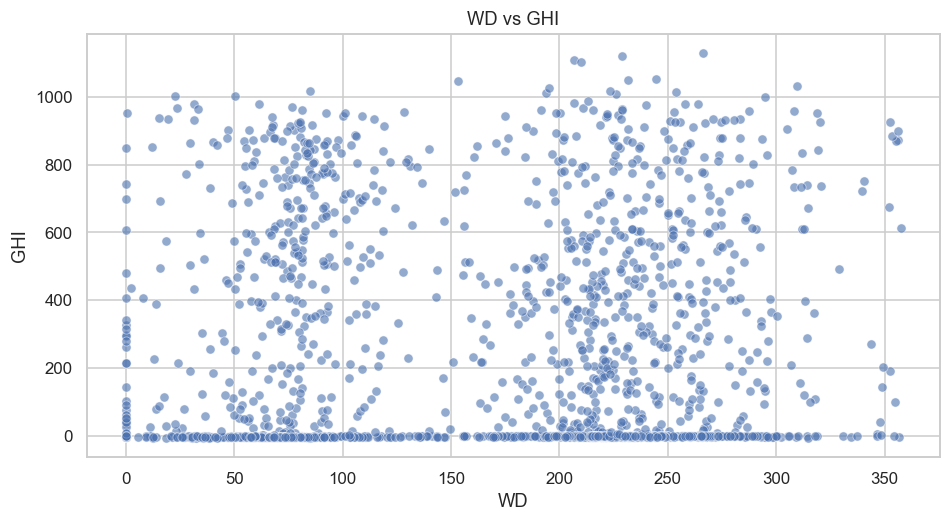

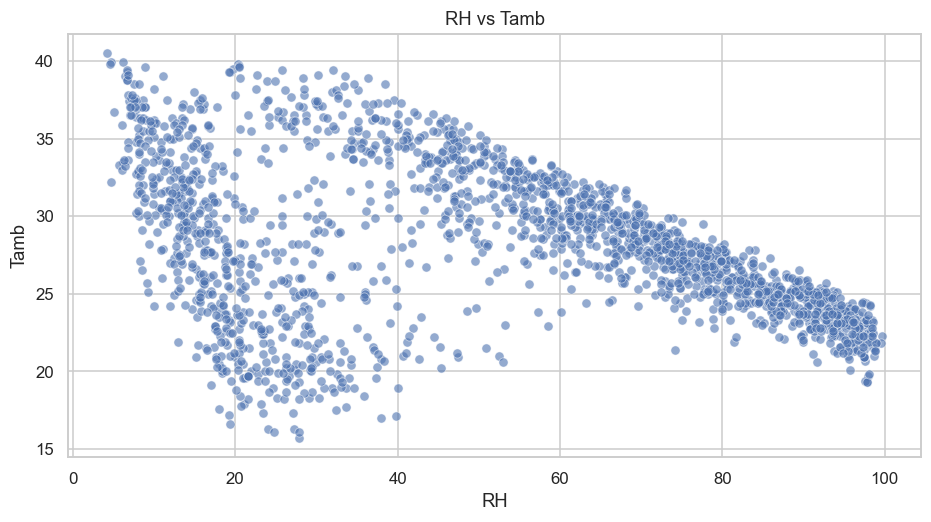

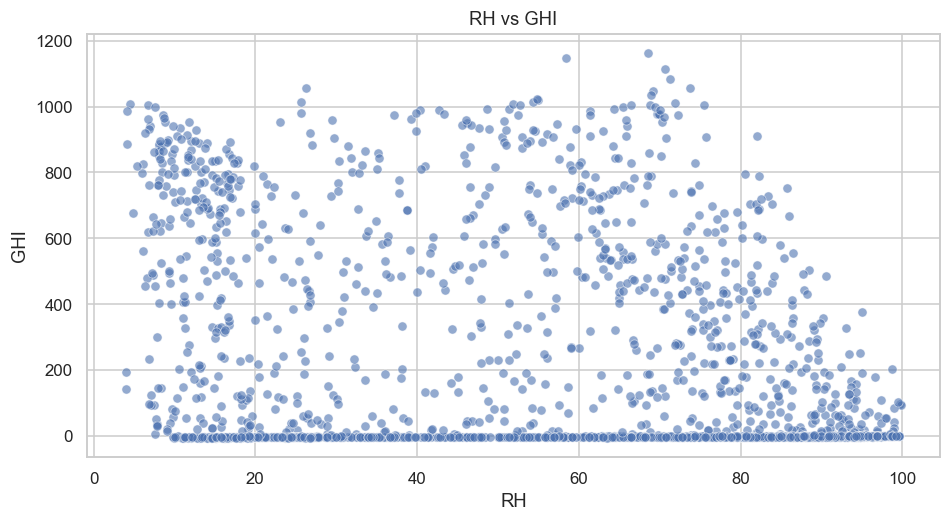

In [11]:
#  Correlation heatmap and scatter plots
corr_cols = [c for c in ["GHI", "DNI", "DHI", "ModA", "ModB", "TModA",
                         "TModB", "Tamb", "RH", "WS", "WSgust"] if c in df_clean.columns]
if corr_cols:
    corr = df_clean[corr_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag", center=0)
    plt.title(f"{COUNTRY} — Correlation heatmap")
    plt.show()

# Scatter plots: WS, WSgust, WD vs GHI
for c in ["WS", "WSgust", "WD"]:
    if c in df_clean.columns and "GHI" in df_clean.columns:
        sns.scatterplot(data=df_clean.sample(
            n=min(2000, len(df_clean))), x=c, y="GHI", alpha=0.6)
        plt.title(f"{c} vs GHI")
        plt.show()

# RH vs Tamb and RH vs GHI
if "RH" in df_clean.columns and "Tamb" in df_clean.columns:
    sns.scatterplot(data=df_clean.sample(
        n=min(2000, len(df_clean))), x="RH", y="Tamb", alpha=0.6)
    plt.title("RH vs Tamb")
    plt.show()

if "RH" in df_clean.columns and "GHI" in df_clean.columns:
    sns.scatterplot(data=df_clean.sample(
        n=min(2000, len(df_clean))), x="RH", y="GHI", alpha=0.6)
    plt.title("RH vs GHI")
    plt.show()

Wind analysis (radial histogram / simplified wind rose)

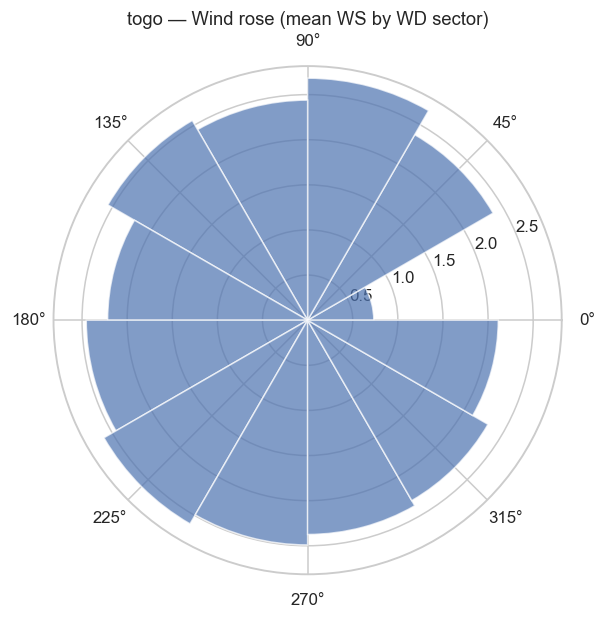

In [12]:
#  Wind analysis (radial histogram / simplified wind rose)
if "WS" in df_clean.columns and "WD" in df_clean.columns:
    # Bin wind direction into compass sectors
    bins = np.arange(0, 361, 30)  # 12 sectors
    labels = (bins[:-1] + 15).tolist()
    df_clean["WD_bin"] = pd.cut(df_clean["WD"] %
                                360, bins=bins, right=False, labels=labels)
    wind_summary = df_clean.groupby("WD_bin")["WS"].mean().reindex(labels)
    # radial bar plot
    theta = np.deg2rad([float(x) for x in wind_summary.index])
    radii = wind_summary.values
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=np.deg2rad(30), bottom=0.0, alpha=0.7)
    ax.set_title(f"{COUNTRY} — Wind rose (mean WS by WD sector)")
    plt.show()
else:
    print("Skipping wind rose: WS or WD missing")

Histograms (GHI and WS)

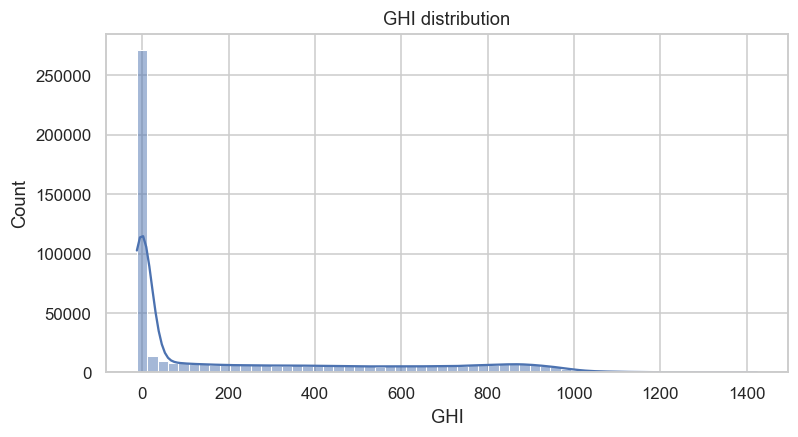

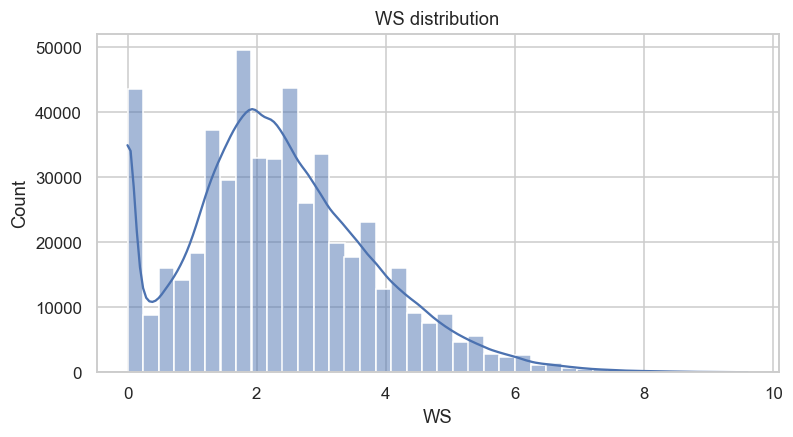

In [13]:
#  Histograms (GHI and WS)
if "GHI" in df_clean.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean["GHI"].dropna(), bins=60, kde=True)
    plt.title("GHI distribution")
    plt.show()

if "WS" in df_clean.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean["WS"].dropna(), bins=40, kde=True)
    plt.title("WS distribution")
    plt.show()

Temperature & RH analysis, bubble chart

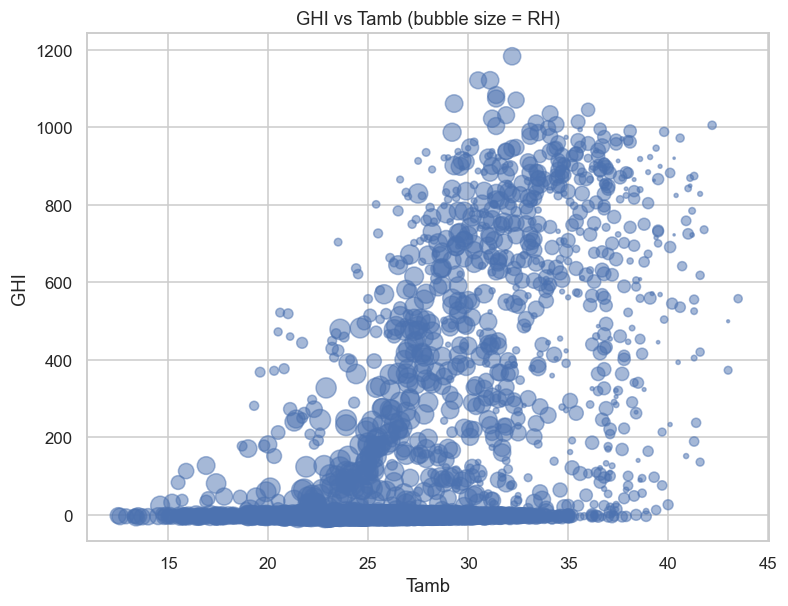

In [ ]:
#  Temperature & RH analysis, bubble chart
# Bubble chart: GHI vs Tamb with bubble size = RH (or BP if present)
if "GHI" in df_clean.columns and "Tamb" in df_clean.columns and ("RH" in df_clean.columns or "BP" in df_clean.columns):
    size_col = "RH" if "RH" in df_clean.columns else "BP"
    sample = df_clean.dropna(subset=["GHI", "Tamb", size_col]).sample(
        n=min(2000, len(df_clean)))
    plt.figure(figsize=(8, 6))
    plt.scatter(sample["Tamb"], sample["GHI"], s=(
        sample[size_col] - sample[size_col].min() + 1)*2, alpha=0.5)
    plt.xlabel("Tamb")
    plt.ylabel("GHI")
    plt.title(f"GHI vs Tamb (bubble size = {size_col})")
    plt.show()
else:
    print("Skipping bubble chart: missing columns")